# DSO599 LLM Final Project
Important:
- Remember to **update** the gemini API key before you run everything
- Also remember to **remove** your API key after using

# 1. Data Ingestion
- Currently finish a. Youtube data pipeline. Feel free to include code for b. second data source
- This part is using models/gemini-2.5-flash model

## a. Youtube data pipeline

In [ ]:
# --- 1. SETUP & IMPORTS ---
!pip install -q google-api-python-client google-auth-oauthlib yt-dlp pandas google-generativeai isodate

import os
import json
import csv
import time
import pandas as pd
import numpy as np
from datetime import datetime
from isodate import parse_duration
import yt_dlp
from googleapiclient.discovery import build
import google.generativeai as genai

In [ ]:
# --- 2. CONFIGURATION ---
YOUTUBE_API_KEY = ""
GEMINI_API_KEY = ""

In [ ]:
genai.configure(api_key=GEMINI_API_KEY)
print("Checking for stuck files in Gemini storage...")
files = list(genai.list_files())

if not files:
    print("No files found. Storage is clean.")
else:
    for f in files:
        print(f"Deleting stuck file: {f.name} (URI: {f.uri})")
        try:
            genai.delete_file(f.name)
        except Exception as e:
            print(f"Error deleting {f.name}: {e}")

print("Cleanup complete.")

Checking for stuck files in Gemini storage...
Deleting stuck file: files/75cet0n7zp97 (URI: https://generativelanguage.googleapis.com/v1beta/files/75cet0n7zp97)
Deleting stuck file: files/z6i3zvd2fisl (URI: https://generativelanguage.googleapis.com/v1beta/files/z6i3zvd2fisl)
Deleting stuck file: files/hpjo1klwgn5i (URI: https://generativelanguage.googleapis.com/v1beta/files/hpjo1klwgn5i)
Deleting stuck file: files/ruofundtpxx4 (URI: https://generativelanguage.googleapis.com/v1beta/files/ruofundtpxx4)
Cleanup complete.


In [ ]:
# --- UPDATED SEARCH STRATEGY ---
SEARCH_QUERIES = [
    # 1. The "Roadmap" Queries (Crucial for the "4-week plan" question)
    "data science interview study plan 4 weeks",
    "how to learn data analyst in 3 months roadmap",
    "data science interview preparation schedule",

    # 2. The "Technical" Queries (For SQL/Python specific advice)
    "common sql interview questions for data scientists",
    "python data science interview questions and answers",

    # 3. The "Behavioral" Queries (For the STAR method question)
    "STAR method behavioral interview data science",
    "data analyst behavioral interview questions and answers"
]

# --- UPDATED FILTERS ---
MIN_VIEW_COUNT = 10000       # Keep high to ensure quality
MAX_DURATION_MINS = 45       # INCREASED: Roadmaps are often long!
MIN_LIKE_RATIO = 0.02        # Standard quality check
TOP_N_VIDEOS = 8             # INCREASED: Get more diverse advice

### Youtube video selection justification

- Module: Automated Video Selection & Evaluation
- Objective: To programmatically identify, score, and select high-quality Data Science career advice videos while filtering out clickbait, low-quality content, or irrelevant formats (e.g., Shorts).

1. Search Strategy (Broad Casting)
- Logic: We query the YouTube API with specific intent-based keywords (e.g., "study plan 4 weeks", "STAR method").
- Justification: Using multiple specific queries ensures diversity in the candidate pool (Roadmaps vs. Technical vs. Behavioral) rather than just getting the generic "Data Science" trending page.

2. Metadata Retrieval (Batching)
- Logic: We collect unique video IDs and fetch deep metadata (statistics, duration) in batches of 50.
- Justification: Batching prevents HTTP 400 errors and respects YouTube API quota limits.

3. Quality Scoring Formula
- Formula: Score = (Views * 0.3) + (Likes * 20)
- Justification:
  - Views (0.3 weight): Measures reach and general popularity.
  - Likes (20 weight): Measures actual viewer satisfaction. We heavily weight likes to favor high-quality educational content over clickbait that gets views but low engagement.

4. Filtering Gates (The "Quality Control")
- Minimum Views: 10,000 (Ensures established credibility).
- Duration Window: 2 mins to 45 mins.
  - Why? Removes "Shorts" (too shallow for deep learning) and 3-hour unedited livestreams (too noisy/costly to process).
- Engagement Ratio: > 2% Like-to-View Ratio.
  - Why? Filters out clickbait videos where users watch but don't value the content.

5. Domain-Specific "Roadmap Boost"
- Logic: If the title contains "roadmap" or "plan", the score is multiplied by 1.5x.
- Justification: Our Digital Twin specifically needs to generate schedules (e.g., "4-week plan"). This logic forces the system to prioritize content that contains timeline data over generic advice.

In [ ]:
# --- 3. SEARCH & JUSTIFICATION MODULE ---

def get_youtube_service():
    return build('youtube', 'v3', developerKey=YOUTUBE_API_KEY)

def search_and_evaluate_videos(youtube, queries):
    print(f"--- Re-establishing Metadata (Searching) ---")
    candidates = []

    # A. Collect IDs
    for query in queries:
        print(f"Searching for: '{query}'...")
        try:
            request = youtube.search().list(
                part="snippet", maxResults=5, q=query, type="video", relevanceLanguage="en", order="relevance"
            )
            response = request.execute()
            for item in response['items']:
                candidates.append(item['id']['videoId'])
        except Exception as e:
            print(f"Warning: Search failed for query '{query}': {e}")

    candidates = list(set(candidates))
    print(f"Found {len(candidates)} unique candidate videos. Getting details...")

    # B. Get Details (BATCHED)
    video_details_items = []
    chunk_size = 50

    for i in range(0, len(candidates), chunk_size):
        chunk = candidates[i:i + chunk_size]
        try:
            details_request = youtube.videos().list(
                part="snippet,contentDetails,statistics",
                id=','.join(chunk)
            )
            details_response = details_request.execute()
            video_details_items.extend(details_response.get('items', []))
        except Exception as e:
            print(f"Warning: Failed to get details for batch {i}: {e}")

    # C. Evaluate & Score
    evaluated_videos = []
    for item in video_details_items:
        stats = item['statistics']
        snippet = item['snippet']

        views = int(stats.get('viewCount', 0))
        likes = int(stats.get('likeCount', 0))
        duration_sec = parse_duration(item['contentDetails']['duration']).total_seconds()
        duration_mins = duration_sec / 60

        like_ratio = likes / views if views > 0 else 0
        score = (views * 0.3) + (likes * 20)

        # Filters using GLOBAL variables
        keep = True
        reason = ""
        if views < MIN_VIEW_COUNT: keep = False; reason = "Low Views"
        elif duration_mins > MAX_DURATION_MINS: keep = False; reason = "Too Long"
        elif duration_mins < 2: keep = False; reason = "Too Short"
        elif like_ratio < MIN_LIKE_RATIO: keep = False; reason = "Low Engagement"

        # Boost Roadmaps
        if "roadmap" in snippet['title'].lower() or "plan" in snippet['title'].lower():
            score *= 1.5

        entry = {
            'id': item['id'],
            'title': snippet['title'],
            'channel': snippet['channelTitle'],
            'quality_score': int(score),
            'keep': keep,
            'reason': reason
        }
        evaluated_videos.append(entry)

    # Sort and Select using TOP_N_VIDEOS variable
    valid_videos = [v for v in evaluated_videos if v['keep']]
    valid_videos.sort(key=lambda x: x['quality_score'], reverse=True)

    final_selection = valid_videos[:TOP_N_VIDEOS]

    print(f"\n--- Selection Report ({len(final_selection)} selected based on TOP_N_VIDEOS={TOP_N_VIDEOS}) ---")
    for v in final_selection:
        print(f"[SELECTED] {v['title'][:40]}... (Score: {v['quality_score']})")

    return final_selection

In [ ]:
# --- 4. DOWNLOAD & TRANSCRIPTION ---
# --- DEFINE VARIABLES FIRST ---
VIDEO_DOWNLOAD_DIR = "ds_video_downloads"

# --- ROBUST DOWNLOAD FUNCTION ---
def download_video(video_id, output_dir=VIDEO_DOWNLOAD_DIR):
    if not os.path.exists(output_dir): os.makedirs(output_dir)
    output_path = os.path.join(output_dir, f"{video_id}.mp4")

    if os.path.exists(output_path):
        return output_path

    ydl_opts = {
        'format': 'bestvideo[ext=mp4]+bestaudio[ext=m4a]/best[ext=mp4]/best',
        'outtmpl': output_path,
        'quiet': True,
        'cookiefile': 'cookies.txt',
        'user_agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
    }

    print(f"Downloading {video_id}...")
    try:
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            ydl.download([f"https://www.youtube.com/watch?v={video_id}"])
        if os.path.exists(output_path) and os.path.getsize(output_path) > 1024:
            return output_path
    except Exception as e:
        print(f"Download Error: {e}")
    return None

def transcribe_with_gemini(video_path, video_title):
    genai.configure(api_key=GEMINI_API_KEY)
    print(f"Uploading {video_path}...")
    try:
        video_file = genai.upload_file(path=video_path)
        while video_file.state.name == "PROCESSING":
            time.sleep(5)
            video_file = genai.get_file(video_file.name)

        if video_file.state.name == "FAILED": return None

        print(f"Transcribing '{video_title[:20]}...'")
        model = genai.GenerativeModel("models/gemini-2.5-flash")

        prompt = f"""
        You are an expert data science transcriber.
        Transcribe the following video into clear, grammatically correct text suitable for a knowledge base.
        RULES:
        1. Ignore intro music, sponsorship reads, and filler words.
        2. Focus on instructional content: specific tips, technical explanations, and advice.
        3. Output ONLY the transcript text.
        """

        response = model.generate_content([prompt, video_file])

        try: genai.delete_file(video_file.name)
        except: pass
        return response.text
    except Exception as e:
        print(f"Gemini Error: {e}")
        return None

In [ ]:
# --- 5. MAIN PIPELINE ---
# --- CONFIGURATION ---
FINAL_CORPUS_FILE = "youtube_data_corpus.csv"
VIDEO_DOWNLOAD_DIR = "ds_video_downloads"

def build_full_corpus():
    # 1. Search (Get the target list)
    youtube = get_youtube_service()
    selected_videos = search_and_evaluate_videos(youtube, SEARCH_QUERIES)

    # 2. Load Existing Data (The "Check" Phase)
    existing_ids = set()
    if os.path.exists(FINAL_CORPUS_FILE):
        try:
            existing_df = pd.read_csv(FINAL_CORPUS_FILE)
            existing_ids = set(existing_df['id'].tolist())
            print(f"\n--- Loaded {len(existing_ids)} existing videos from {FINAL_CORPUS_FILE} ---")
        except Exception as e:
            print(f"Warning: Could not read existing corpus: {e}")

    corpus_data = [] # Store ONLY new entries here

    print(f"\n--- Processing Queue: {len(selected_videos)} Videos ---")

    for video in selected_videos:
        video_id = video['id']
        title = video['title']
        channel = video['channel']
        corpus_id = f"yt_{video_id}"

        # CHECK 1: Do we already have this transcript?
        if corpus_id in existing_ids:
            print(f"[SKIP] '{title[:20]}...' (Already in Corpus)")
            continue

        # CHECK 2: Do we have the file locally?
        local_path = os.path.join(VIDEO_DOWNLOAD_DIR, f"{video_id}.mp4")

        # If not, try to download it
        if not os.path.exists(local_path):
             local_path = download_video(video_id)

        # If still missing, give up on this one
        if not local_path or not os.path.exists(local_path):
            print(f"[MISSING] {video_id} (Download Failed).")
            continue

        # ACTION: Transcribe (The "Processing" Phase)
        print(f"[PROCESSING] Transcribing '{title[:20]}...'")
        transcript = transcribe_with_gemini(local_path, title)

        if transcript:
            corpus_data.append({
                "id": corpus_id,
                "source": "youtube",
                "title": title,
                "channel": channel,
                "url": f"https://www.youtube.com/watch?v={video_id}",
                "text": transcript
            })
            print(f"  -> SUCCESS! Saved.")

            # *** CRITICAL: SLEEP TO PREVENT 429 ERRORS ***
            print("  -> Sleeping 30s to respect Rate Limits...")
            time.sleep(30)
        else:
            print(f"  -> FAILED: Could not transcribe.")

    # 3. Save & Merge
    if corpus_data:
        new_df = pd.DataFrame(corpus_data)

        # Ensure standard columns
        cols = ["id", "source", "title", "url", "text", "channel"]
        for c in cols:
            if c not in new_df.columns: new_df[c] = ""
        new_df = new_df[cols]

        # Append to existing file if it exists
        if os.path.exists(FINAL_CORPUS_FILE):
            final_df = pd.concat([pd.read_csv(FINAL_CORPUS_FILE), new_df], ignore_index=True)
        else:
            final_df = new_df

        final_df.to_csv(FINAL_CORPUS_FILE, index=False)
        print(f"\n--- DONE: Added {len(new_df)} new videos. Total Corpus: {len(final_df)} ---")
        return final_df
    else:
        print("\n--- No new videos needed processing. Corpus is up to date. ---")
        if os.path.exists(FINAL_CORPUS_FILE):
            return pd.read_csv(FINAL_CORPUS_FILE)
        return None

if __name__ == "__main__":
    df = build_full_corpus()
    if df is not None:
        pd.set_option('display.max_colwidth', 50)
        display(df.tail()) # Show the latest additions

--- Re-establishing Metadata (Searching) ---
Searching for: 'data science interview study plan 4 weeks'...
Searching for: 'how to learn data analyst in 3 months roadmap'...
Searching for: 'data science interview preparation schedule'...
Searching for: 'common sql interview questions for data scientists'...
Searching for: 'python data science interview questions and answers'...
Searching for: 'STAR method behavioral interview data science'...
Searching for: 'data analyst behavioral interview questions and answers'...
Found 31 unique candidate videos. Getting details...

--- Selection Report (8 selected based on TOP_N_VIDEOS=8) ---
[SELECTED] How to Answer Behavioral Interview Quest... (Score: 1881328)
[SELECTED] How I'd become a data analyst (if i had ... (Score: 1240930)
[SELECTED] How I'd Learn Data Analytics in 2025 | 3... (Score: 877485)
[SELECTED] The Complete Data Analyst Roadmap... (Score: 740804)
[SELECTED] Data Analyst Roadmap 2023 | Learn data a... (Score: 535344)
[SELECTED] B

,id,source,title,url,text,channel
3,yt_YRJbhFLLPyE,youtube,The Complete Data Analyst Roadmap,https://www.youtube.com/watch?v=YRJbhFLLPyE,"If you want to become a data analyst, there ar...",Programming with Mosh
4,yt_b_n-hhtMbXA,youtube,Data Analyst Roadmap 2023 | Learn data analyti...,https://www.youtube.com/watch?v=b_n-hhtMbXA,Data analysis is a career role that doesn't re...,codebasics
5,yt_cffsJjNTsH8,youtube,SQL interview questions and answers | Entry le...,https://www.youtube.com/watch?v=cffsJjNTsH8,If you've got an internship or an entry-level ...,Aaron Oliver
6,yt_2uM7gYuOvr4,youtube,BEHAVIOURAL Interview Questions & Answers! (Th...,https://www.youtube.com/watch?v=2uM7gYuOvr4,Behavioral interview questions are probably th...,CareerVidz
7,yt_Td-cmLfQ7uU,youtube,Real Data Science SQL Interview Questions and ...,https://www.youtube.com/watch?v=Td-cmLfQ7uU,Welcome back to another video. Some of you hav...,Tina Huang


## b. second data source
feel free to add code here, then update the RAG pipeline below (look for 2. Placeholder for Teammate's CSV )

# 2. RAG Pipeline
Please notice this part is using models/gemini-2.5-flash-lite now due to quota, but feel free to change this to models/gemini-2.5-flash if needed

## a. Retrieve

In [ ]:
# --- 1. SETUP & IMPORTS ---
import pandas as pd
import numpy as np
import google.generativeai as genai
from typing import List, Dict

# Config
EMBEDDING_MODEL = "models/text-embedding-004" # Best model for retrieval
CORPUS_FILE = "youtube_data_corpus.csv"

# Configure GenAI
genai.configure(api_key=GEMINI_API_KEY)

In [ ]:
# --- 2. DATA LOADING ---
def load_and_merge_data(primary_file=CORPUS_FILE):
    """
    Loads the primary YouTube corpus and prepares a slot for
    your teammate's future data source.
    """
    # 1. Load YouTube Data
    if os.path.exists(primary_file):
        df_yt = pd.read_csv(primary_file)
        print(f"Loaded {len(df_yt)} videos from {primary_file}")
    else:
        print(f"WARNING: {primary_file} not found. Did you run the previous step?")
        return []

    # 2. Placeholder for Teammate's CSV (Commented out for now)
    # teammate_file = "teammate_data.csv"
    # if os.path.exists(teammate_file):
    #     df_team = pd.read_csv(teammate_file)
    #     # Ensure columns match: id, source, title, url, text
    #     df_yt = pd.concat([df_yt, df_team], ignore_index=True)

    # Convert to list of dicts
    corpus = df_yt.to_dict(orient="records")
    return corpus

In [ ]:
# --- 3. CHUNKING ENGINE ---
def chunk_text(text: str, chunk_size: int = 500, overlap: int = 50) -> List[str]:
    """
    Simple chunker: Splits text into chunks of ~500 words with overlap.
    Essential for RAG so we retrieve specific tips, not whole transcripts.
    """
    words = text.split()
    chunks = []

    for i in range(0, len(words), chunk_size - overlap):
        chunk_words = words[i : i + chunk_size]
        chunk_str = " ".join(chunk_words)
        if len(chunk_str) > 50: # Filter out tiny noise chunks
            chunks.append(chunk_str)

    return chunks

def process_corpus_into_chunks(corpus: List[Dict]):
    """
    Takes the raw video list and explodes it into smaller searchable chunks.
    """
    chunked_corpus = []

    print("Chunking corpus...")
    for entry in corpus:
        # Create chunks
        raw_text = str(entry.get('text', ''))
        text_chunks = chunk_text(raw_text)

        for i, chunk in enumerate(text_chunks):
            # Create a new entry for each chunk, preserving metadata
            chunk_entry = entry.copy()
            chunk_entry['text'] = chunk
            chunk_entry['chunk_id'] = f"{entry['id']}_chunk_{i}"
            chunked_corpus.append(chunk_entry)

    print(f"Created {len(chunked_corpus)} chunks from {len(corpus)} source items.")
    return chunked_corpus

In [ ]:
# --- 4. EMBEDDING ENGINE (REAL GEMINI) ---
def get_batch_embeddings(texts: List[str]):
    """
    Generates embeddings using Gemini API in batches to avoid rate limits.
    """
    embeddings = []
    batch_size = 10 # Conservative batch size for free tier

    print(f"Generating embeddings for {len(texts)} chunks...")

    for i in range(0, len(texts), batch_size):
        batch = texts[i : i + batch_size]
        try:
            # Task type 'retrieval_document' optimizes vectors for searching
            result = genai.embed_content(
                model=EMBEDDING_MODEL,
                content=batch,
                task_type="retrieval_document"
            )
            embeddings.extend(result['embedding'])
        except Exception as e:
            print(f"Error embedding batch {i}: {e}")
            # Fallback: fill with zeros to prevent index misalignment (or handle retry)
            embeddings.extend([ [0]*768 for _ in range(len(batch)) ])

    return np.array(embeddings)

In [ ]:
# --- 5. RETRIEVAL ENGINE ---
class VectorStore:
    def __init__(self, chunked_corpus):
        self.corpus = chunked_corpus
        self.embeddings = None

    def build_index(self):
        # Extract just the text for embedding
        texts = [item['text'] for item in self.corpus]
        self.embeddings = get_batch_embeddings(texts)
        print("Vector Store built successfully.")

    def retrieve(self, query: str, top_k: int = 3):
        # 1. Embed the query
        query_vec = genai.embed_content(
            model=EMBEDDING_MODEL,
            content=query,
            task_type="retrieval_query"
        )['embedding']
        query_vec = np.array(query_vec)

        # 2. Calculate Cosine Similarity
        # (Dot product of normalized vectors)
        scores = np.dot(self.embeddings, query_vec)

        # 3. Get Top K indices
        top_indices = np.argsort(scores)[::-1][:top_k]

        # 4. Return results
        results = []
        for idx in top_indices:
            item = self.corpus[idx]
            results.append({
                'score': float(scores[idx]),
                'source': item['source'],
                'title': item['title'],
                'text': item['text'],
                'url': item.get('url', 'N/A')
            })
        return results

In [ ]:
# --- 6. EXECUTION & TEST ---

# A. Load
raw_data = load_and_merge_data()

# B. Process (Chunk)
chunked_data = process_corpus_into_chunks(raw_data)

# C. Build Index (Embed)
# NOTE: This calls the API. If you have many videos, it might take a moment.
vector_store = VectorStore(chunked_data)
vector_store.build_index()

Loaded 8 videos from youtube_data_corpus.csv
Chunking corpus...
Created 35 chunks from 8 source items.
Generating embeddings for 35 chunks...
Vector Store built successfully.


## b. Generation

In [ ]:
# --- COMPLETING SECTION 2: RAG GENERATION & COMPARISON ---

# 1. Define the "Baseline" (No RAG) function
def generate_baseline(query):
    try:
        model = genai.GenerativeModel("models/gemini-2.5-flash-lite")
        prompt = f"""
        You are a helpful assistant.
        Question: {query}
        Answer:
        """
        return model.generate_content(prompt).text
    except Exception as e:
        return f"Baseline Error: {e}"

# 2. Define the "RAG" (With Retrieval) function
def generate_rag_basic(query, vector_store):
    try:
        # A. Retrieve top chunks
        docs = vector_store.retrieve(query, top_k=10)

        # B. Build Context
        context_str = "\n\n".join([f"SOURCE: {d['title']}\nTEXT: {d['text']}" for d in docs])

        # C. Prompt
        prompt = f"""
        You are a helpful assistant. Answer the user's question using ONLY the context provided below.

        CONTEXT:
        {context_str}

        USER QUESTION: {query}

        ANSWER:
        """
        model = genai.GenerativeModel("models/gemini-2.5-flash-lite")
        return model.generate_content(prompt).text
    except Exception as e:
        return f"RAG Error: {e}"

# --- RUN THE COMPARISON ---
test_query = "I am weak in SQL and have 4 weeks to prepare for a DS interview. How should I prepare?"

print(f"--- SECTION 2 DELIVERABLE: RAG VS BASELINE ---\n")
print("Status: Cooling down API for 30 seconds to reset quota...")
time.sleep(30) # Wait for previous tasks to clear

print(f"Query: '{test_query}'\n")

print(">>> 1. BASELINE ANSWER (Generic LLM):")
print("-" * 40)
print(generate_baseline(test_query))
print("-" * 40 + "\n")

print("Status: Pausing 10s before RAG generation...")
time.sleep(10) # Safety pause

print(">>> 2. RAG ANSWER (Your Digital Twin System):")
print("-" * 40)
print(generate_rag_basic(test_query, vector_store))
print("-" * 40)

--- SECTION 2 DELIVERABLE: RAG VS BASELINE ---

Status: Cooling down API for 30 seconds to reset quota...
Query: 'I am weak in SQL and have 4 weeks to prepare for a DS interview. How should I prepare?'

>>> 1. BASELINE ANSWER (Generic LLM):
----------------------------------------
It's absolutely achievable to build a solid foundation in SQL for your Data Science interview within 4 weeks! Don't be discouraged by feeling weak; focus on a structured and efficient approach. Here's a plan to help you prepare:

## 4-Week SQL Preparation Plan for Data Science Interviews

This plan prioritizes the most common SQL concepts you'll encounter in interviews. We'll break it down week by week.

### Core Principles for Success:

*   **Practice, Practice, Practice:** Reading alone won't cut it. You need to write SQL queries.
*   **Understand the "Why":** Don't just memorize syntax. Grasp the logic behind each command and how it solves a problem.
*   **Focus on Interview-Relevant Topics:** Data Science

# 3. Prompt Engineering
For this part, based on the RAG we build in the previous section, we can further:
- Load the personas
- Test different interations of prompt design

Please notice this part is also using models/gemini-2.5-flash-lite now, but feel free to change this to models/gemini-2.5-flash if needed

In [ ]:
# --- SECTION 3: PROMPT ENGINEERING & ITERATIONS ---
# 1. LOAD PERSONAS (The "User Context")
def load_personas(path="role_based.xlsx"):
    try:
        df = pd.read_excel(path)
        print(f"Loaded {len(df)} user personas.")
        return df
    except Exception as e:
        print(f"Error loading personas: {e}")
        return pd.DataFrame()

df_personas = load_personas()
# Display the first row to confirm it worked
if not df_personas.empty:
    display(df_personas.head(1))

Loaded 5 user personas.


,role_id,target_role,seniority_level,candidate_background,candidate_strengths,candidate_weaknesses,time_horizon,response_style_preference,request_type,user_goal,focus_constraints,expected_output_format,personalization_rules
0,1,Data Scientist,Junior,Business analytics master student transitionin...,"SQL, data visualization","Experiment design, statistics",4 weeks,Structured with concrete examples,Interview prep plan,Pass DS technical interviews,Limited time for deep ML theory,"Sections: priorities, weekly plan, practice re...",Emphasize experiment design basics and applied...


In [ ]:
def run_iteration_1(query, vector_store):
    print(">>> RUNNING ITERATION 1 (Basic RAG)...")

    # Retrieve
    docs = vector_store.retrieve(query, top_k=5)
    context_str = "\n\n".join([f"SOURCE: {d['title']}\nTEXT: {d['text']}" for d in docs])

    # Basic Prompt
    prompt = f"""
    You are a helpful assistant. Answer the question using the context below.

    CONTEXT:
    {context_str}

    QUESTION: {query}

    ANSWER:
    """
    model = genai.GenerativeModel("models/gemini-2.5-flash-lite")
    return model.generate_content(prompt).text

In [ ]:
# --- ITERATION 2: ADVANCED PROMPT (The "Digital Twin") ---
# Techniques Used:
# 1. Role Prompting ("You are an expert coach")
# 2. Few-Shot / Constraint Injection (Using specific user details from Excel)
# 3. Explicit Formatting Rules
def run_iteration_2(query, role_id, vector_store, df_personas):
    print(">>> RUNNING ITERATION 2 (Persona-Aware Twin)...")

    # 1. Get User Profile
    if df_personas.empty: return "Error: No personas loaded."
    persona = df_personas[df_personas['role_id'] == role_id].iloc[0]

    # 2. Retrieve (High Recall)
    docs = vector_store.retrieve(query, top_k=10)
    context_str = "\n\n".join([f"SOURCE: {d['title']}\nTEXT: {d['text']}" for d in docs])

    # 3. Engineer the Advanced Prompt
    system_prompt = f"""
    You are an expert Data Science Interview Coach.

    YOUR STUDENT PROFILE:
    - Target Role: {persona['target_role']}
    - Background: {persona['candidate_background']}
    - Weaknesses: {persona['candidate_weaknesses']}
    - Time Limit: {persona['time_horizon']}

    YOUR INSTRUCTIONS:
    1. Act as a strict but encouraging coach.
    2. Answer the question using ONLY the provided "Expert Context".
    3. CUSTOMIZE your advice: Since the student has {persona['time_horizon']}, prioritize ruthlessly.
    4. FORMATTING: {persona['expected_output_format']}
    5. STYLE: {persona['response_style_preference']}

    EXPERT CONTEXT:
    --------------------------------
    {context_str}
    --------------------------------

    STUDENT QUESTION:
    "{query}"

    COACH RESPONSE:
    """
    model = genai.GenerativeModel("models/gemini-2.5-flash-lite")
    return model.generate_content(system_prompt).text

In [ ]:
# --- EXECUTION & COMPARISON ---
TEST_QUERY = "I am weak in SQL. How should I prepare?"
TEST_ROLE_ID = 1 # Junior DS (4 weeks timeline)

# Run Iteration 1
result_1 = run_iteration_1(TEST_QUERY, vector_store)

# Run Iteration 2
result_2 = run_iteration_2(TEST_QUERY, TEST_ROLE_ID, vector_store, df_personas)

# --- PRINT THE COMPARISON FOR YOUR REPORT ---
print("\n" + "="*80)
print(f"DELIVERABLE: PROMPT ENGINEERING ITERATIONS")
print("="*80)

print(f"\nQUERY: {TEST_QUERY}\n")

print(f"--- ITERATION 1 OUTPUT (Basic) ---")
print(result_1[:1000] + "..." if len(result_1) > 1000 else result_1) # Truncate if too long

print(f"\n\n--- ITERATION 2 OUTPUT (Advanced/Digital Twin) ---")
print(result_2)
print("="*80)

>>> RUNNING ITERATION 1 (Basic RAG)...
>>> RUNNING ITERATION 2 (Persona-Aware Twin)...

DELIVERABLE: PROMPT ENGINEERING ITERATIONS

QUERY: I am weak in SQL. How should I prepare?

--- ITERATION 1 OUTPUT (Basic) ---
To prepare for SQL, you should focus on learning the basics of relational databases and practice writing queries. Key topics to cover include basic queries like SELECT, WHERE, LIKE, DISTINCT, BETWEEN, GROUP BY, and ORDER BY. You should also learn advanced queries such as CTEs, Subqueries, and Window Functions, as well as different types of Joins (Left, Right, Inner, Full). You do not need to learn database creation, indexes, or triggers, as these are rarely used by data analysts.

There are several free resources available to help you learn SQL:
*   Khan Academy course
*   W3Schools SQL Tutorial: https://www.w3schools.com/sql/
*   SQLBolt: https://sqlbolt.com/
*   YouTube tutorials

If you prefer paid options, consider courses like:
*   SQL course for data professionals: htt

# 4. LLM evaluation

- We evaluate two systems built on the same retrieval pipeline:
  1. baseline zero-shot RAG
  2. persona-aware Digital Twin that adds role prompting, time constraints, and structured output rules.

- Due to the cost of human evaluation, we assess a representative subset with three personas and four interview question types, resulting in twenty-four outputs.
- Each response is scored by five evaluators across five dimensions.
- Results show the Digital Twin consistently outperforms the baseline, especially in personalization, actionability, and clarity.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os

# Replace the path the actual folder name
os.chdir('/content/drive/MyDrive/usc_fall_2025/DSO 599 LLM/Final Project')

# Confirm that the files are accessible
os.listdir()

Mounted at /content/drive


['code pipeline.ipynb',
 'youtube_data_corpus.csv',
 'LLM_full_pipeline.ipynb',
 'Copy_of_LLM_full_pipeline (1).ipynb',
 'role_based.gsheet',
 'inference_outputs_baseline_vs_twin.csv',
 'inference_outputs_baseline_vs_twin.gsheet',
 'Project Plan (Draft).gdoc',
 'inference_all_roles_8queries_baseline_vs_twin.csv',
 'eval_rubric.gsheet',
 'slides_content.gdoc',
 'Evaluation.gsheet',
 'eval_for_analysis.csv',
 'evaluation.ipynb']

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv("eval_for_analysis.csv")

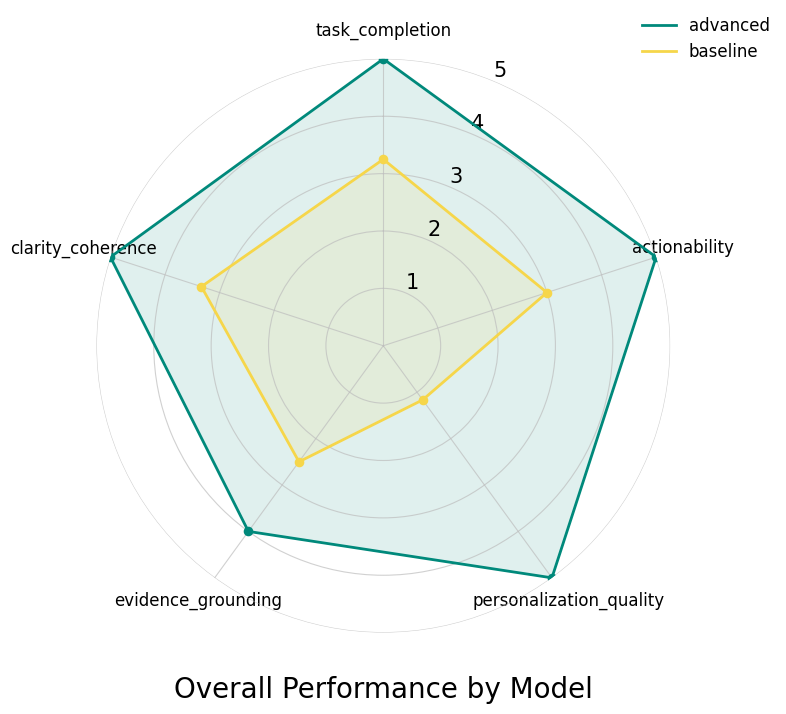

In [ ]:
# -----------------------------
# 2) Palette (yellow + green) from your screenshot
# -----------------------------
# You can tweak these hex codes if you want closer matching to your exact palette.
COLOR_ADV = "#00897B"   # green-teal
COLOR_BASE = "#F6D64A"  # warm yellow
GRID_COLOR = "#BDBDBD"

# -----------------------------
# 3) Radar helper (opaque polygons + markers + title below center + legend upper right)
# -----------------------------
METRICS = ["task_completion", "actionability", "personalization_quality", "evidence_grounding", "clarity_coherence"]

def radar_plot(ax, values_by_label, labels_order, title, rmax=5):
    n = len(labels_order)
    angles = np.linspace(0, 2*np.pi, n, endpoint=False).tolist()
    angles += angles[:1]  # close

    # Axis setup
    ax.set_theta_offset(np.pi / 2)      # start at top
    ax.set_theta_direction(-1)          # clockwise
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels_order, fontsize=12)
    ax.tick_params(pad=10)              # push metric labels outward (prevents overlap with title)

    # Radial ticks
    ax.set_ylim(0, rmax)
    ax.set_yticks([1, 2, 3, 4, 5])
    ax.set_yticklabels(["1", "2", "3", "4", "5"], fontsize=15)
    ax.yaxis.grid(True, color=GRID_COLOR, linewidth=0.8, alpha=0.7)
    ax.xaxis.grid(True, color=GRID_COLOR, linewidth=0.8, alpha=0.7)

    # Remove outer circle spine
    ax.spines["polar"].set_visible(False)

    # Plot series
    for name, vals in values_by_label.items():
        vals = vals + vals[:1]  # close
        if name.lower() == "advanced":
            color = COLOR_ADV
        elif name.lower() == "baseline":
            color = COLOR_BASE
        else:
            color = None

        ax.plot(angles, vals, linewidth=2.0, label=name, color=color)
        ax.fill(angles, vals, alpha=0.12, color=color)
        # Dot markers at each vertex (intersection)
        ax.scatter(angles[:-1], vals[:-1], s=35, color=color, zorder=3)

    # Title below center (use negative y in axes coords)
    ax.text(0.5, -0.1, title, transform=ax.transAxes, ha="center", va="center", fontsize=20)

    # Legend upper right
    ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1), frameon=False, fontsize=12)

# -----------------------------
# 4) Build "Overall" (across roles) and per-role charts
# -----------------------------
# Overall: average across all rows per model
overall = df.groupby("model")[METRICS].mean().reset_index()
values_overall = {
    row["model"]: [row[m] for m in METRICS]
    for _, row in overall.iterrows()
}

# Plot overall
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)
radar_plot(ax, values_overall, METRICS, "Overall Performance by Model")
plt.tight_layout()
plt.show()

# # Plot per role_id
# for role_id, g in df.groupby("role_id"):
#     role_name = g["role_description"].iloc[0]
#     role_avg = g.groupby("model")[METRICS].mean().reset_index()
#     values_role = {
#         row["model"]: [row[m] for m in METRICS]
#         for _, row in role_avg.iterrows()
#     }

#     fig = plt.figure(figsize=(8, 8))
#     ax = plt.subplot(111, polar=True)
#     radar_plot(ax, values_role, METRICS, f"Role {role_id}: {role_name}")
#     plt.tight_layout()
#     plt.show()



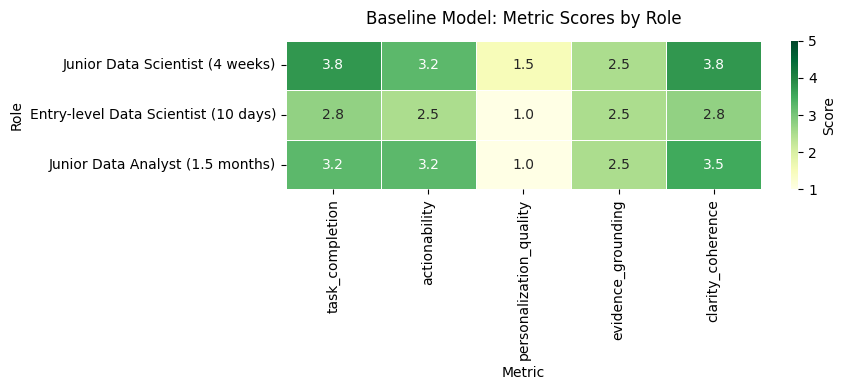

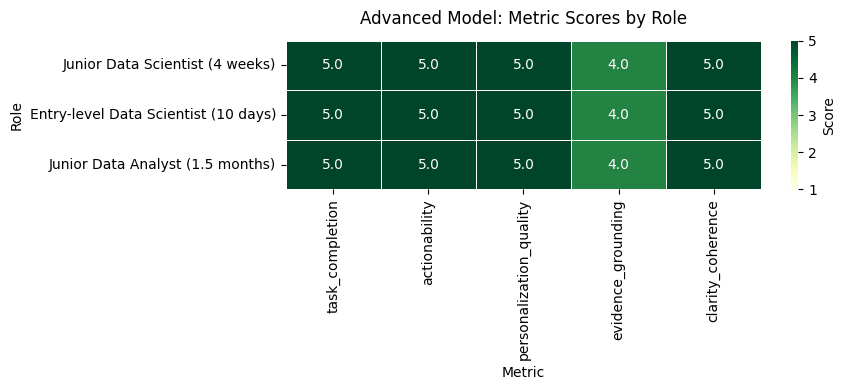

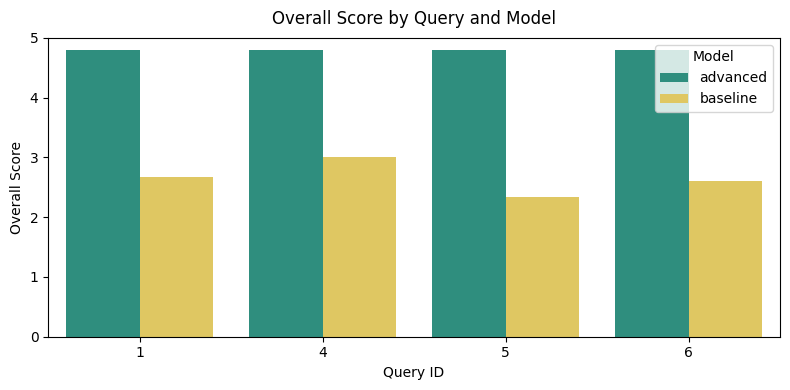

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------
# CONFIG
# ----------------------------
metric_cols = [
    "task_completion",
    "actionability",
    "personalization_quality",
    "evidence_grounding",
    "clarity_coherence"
]

ROLE_LABELS = {
    1: "Junior Data Scientist (4 weeks)",
    5: "Entry-level Data Scientist (10 days)",
    7: "Junior Data Analyst (1.5 months)"
}

MODEL_COLORS = {
    "baseline": "#F4D44D",   # yellow
    "advanced": "#1F9E89"    # green
}

# ----------------------------
# PREP DATA
# ----------------------------
df = df.copy()
df["role_label"] = df["role_id"].map(ROLE_LABELS)

# enforce role order for plots
ROLE_ORDER = list(ROLE_LABELS.values())

# ----------------------------
# 1) HEATMAP: ROLE × METRIC
# ----------------------------
def plot_role_metric_heatmap(df, model_name):
    pivot = (
        df[df["model"] == model_name]
        .groupby("role_label")[metric_cols]
        .mean()
        .loc[ROLE_ORDER]
    )

    plt.figure(figsize=(9, 4))
    sns.heatmap(
        pivot,
        annot=True,
        fmt=".1f",
        cmap="YlGn",
        vmin=1,
        vmax=5,
        linewidths=0.5,
        linecolor="white",
        cbar_kws={"label": "Score"}
    )

    plt.title(f"{model_name.capitalize()} Model: Metric Scores by Role", pad=12)
    plt.xlabel("Metric")
    plt.ylabel("Role")
    plt.tight_layout()
    plt.show()


plot_role_metric_heatmap(df, "baseline")
plot_role_metric_heatmap(df, "advanced")

# ----------------------------
# 2) BAR CHART: QUERY × MODEL
# ----------------------------
def plot_query_bar(df):
    agg = (
        df.groupby(["query_id", "model"])["overall_score"]
        .mean()
        .reset_index()
    )

    plt.figure(figsize=(8, 4))
    sns.barplot(
        data=agg,
        x="query_id",
        y="overall_score",
        hue="model",
        palette=MODEL_COLORS
    )

    plt.ylim(0, 5)
    plt.title("Overall Score by Query and Model", pad=10)
    plt.xlabel("Query ID")
    plt.ylabel("Overall Score")
    plt.legend(title="Model")
    plt.tight_layout()
    plt.show()


plot_query_bar(df)


In [ ]:
S